In [ ]:
# !pip3 install shutup # Kills warning/error? messages.
# !pip3 install yfinance
# !pip3 install uncertainties
# !pip3 install nasdaq_stock
import shutup
shutup.please()

In [1]:
#import mmf_setup;mmf_setup.nbinit()
%pylab inline --no-import-all
import pandas as pd
%load_ext autoreload
import sys;sys.path.append('../')

Populating the interactive namespace from numpy and matplotlib


# Matching Pursuit

We start with a simple polynomial fitting demonstration.  Here we fit a signal $s = \sin(2t)$ with polynomials.  This example shows that the regular matching-pursuit algorithm does not do a very good job, but that the orthogonal version can complete the fit, reproducing the results of running `polyfit()` which does a least-squares fit.

/Users/hn/Documents/00_GitHub/Math583-MichaelGone-iFinMath/Demonstrations/../cycles/cycles.py:1002: UserWarning: Best match already in subspace. Bailing with rtol=0.009657525851716992, rank=4.
  warn(


Eq(P_{MP}(t), -0.412695198394638*t**3 + 1.30020610048063*t + 0.141009131171665)

Eq(P_{OMP}(t), -0.680529858865002*t**3 - 0.542968981415419*t**2 + 2.13181023704453*t - 0.00663506418833714)

Eq(P_{\mathrm{polyfit}}(t), -0.68052985886511*t**3 - 0.542968981415243*t**2 + 2.13181023704445*t - 0.00663506418832946)

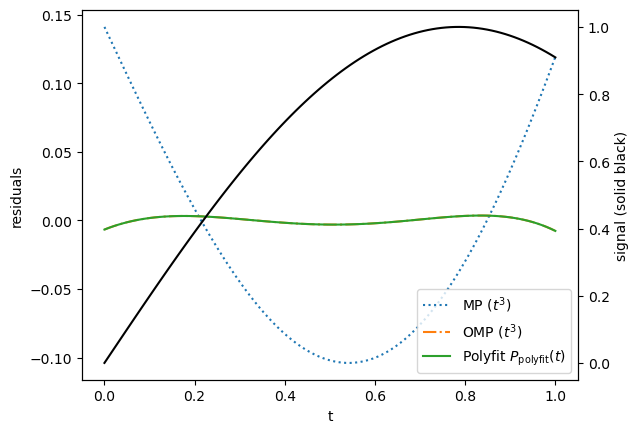

In [2]:
%autoreload
from cycles.cycles import matching_pursuit, orthogonal_matching_pursuit


class MatchPoly(object):
    """Simple "polynomial" matching over [0,1]."""

    t = np.linspace(0, 1, 100)
    powers = np.linspace(0, 10, 1000)
    powers = np.arange(10)

    def __init__(self, **kw):
        self.__dict__.update(kw)
        self.D = self.t[:, np.newaxis] ** self.powers[np.newaxis, :]

        # Normalize and keep track of norms for extrapolators
        self.norms = np.linalg.norm(self.D, axis=0)
        self.D /= self.norms

    def __call__(self, s):
        a_ = s @ self.D
        i = np.argmax(abs(a_))
        d = self.D[:, i]
        a = a_[i]
        f = self.powers[i]
        A = 1/self.norms[i]
        return (d, a, (A, f))

ax = plt.subplot(111)

# You can play with these parameters:
max_rank = 6
powers = np.arange(4)             # Integer powers [0, 1, 2, 3]
#powers = np.linspace(0, 10, 100)  # Overcomplete powers up to 10

match = MatchPoly(powers=powers) 

t = match.t       # Abscissa
s = np.sin(2*t)   # Signal

D, a, f, r = matching_pursuit(s, match=match, rtol=0.001, max_rank=max_rank)
D1, a1, f1, r1 = orthogonal_matching_pursuit(s, match=match, rtol=0.001, max_rank=max_rank)
P3 = np.polyfit(t, s, deg=3)  # Best fit polynomial

ax.plot(t, D @ a - s, ':', label='MP $(t^3)$')
ax.plot(t, D1 @ a1 - s, '-.', label='OMP $(t^3)$')
ax.plot(t, np.polyval(P3, t) - s, '-', label=r"Polyfit $P_{\mathrm{polyfit}}(t)$")
ax.set(xlabel='t', ylabel='residuals')
ax1 = ax.twinx()
ax1.plot(t, s, 'k')
ax1.set(ylabel='signal (solid black)')
ax.legend(loc='lower right')

# Print the equations using SymPy
from sympy import S, Eq, symbols
t_ = S('t')
A, p = map(np.array, zip(*f))
A1, p1 = map(np.array, zip(*f1))
display(Eq(symbols("P_{MP}(t)"), (a * A) @ np.power(t_, p)))
display(Eq(symbols("P_{OMP}(t)"), (a1 * A1) @ np.power(t_, p1)))
display(Eq(symbols("P_{\mathrm{polyfit}}(t)"), np.polyval(P3, t_).expand()))

# Moab Temperatures

In this notebook, we look for cycles in the temperature of Arches National Park near Moab UT, ordered from [NOAA](https://www.ncdc.noaa.gov/cdo-web/datasets)

```
ORDER ID: #2478833
https://www.ncdc.noaa.gov/cdo-web/orders?email=michael.forbes@gmail.com&id=2478833
Stations	
GHCND:USC00420336
Begin Date	1980-06-01 00:00
End Date	2021-01-29 23:59
Data Types	
TMAX TMIN TOBS
Units	
Metric
Custom Flag(s)	
Station Name
Eligible for Certification	No
```

First we read the data:

In [3]:
# Read the data
%pylab inline --no-import-all
import pandas as pd

datafile = '2478833.csv'
data = pd.read_csv(datafile, quotechar='"', parse_dates=[2])

Populating the interactive namespace from numpy and matplotlib


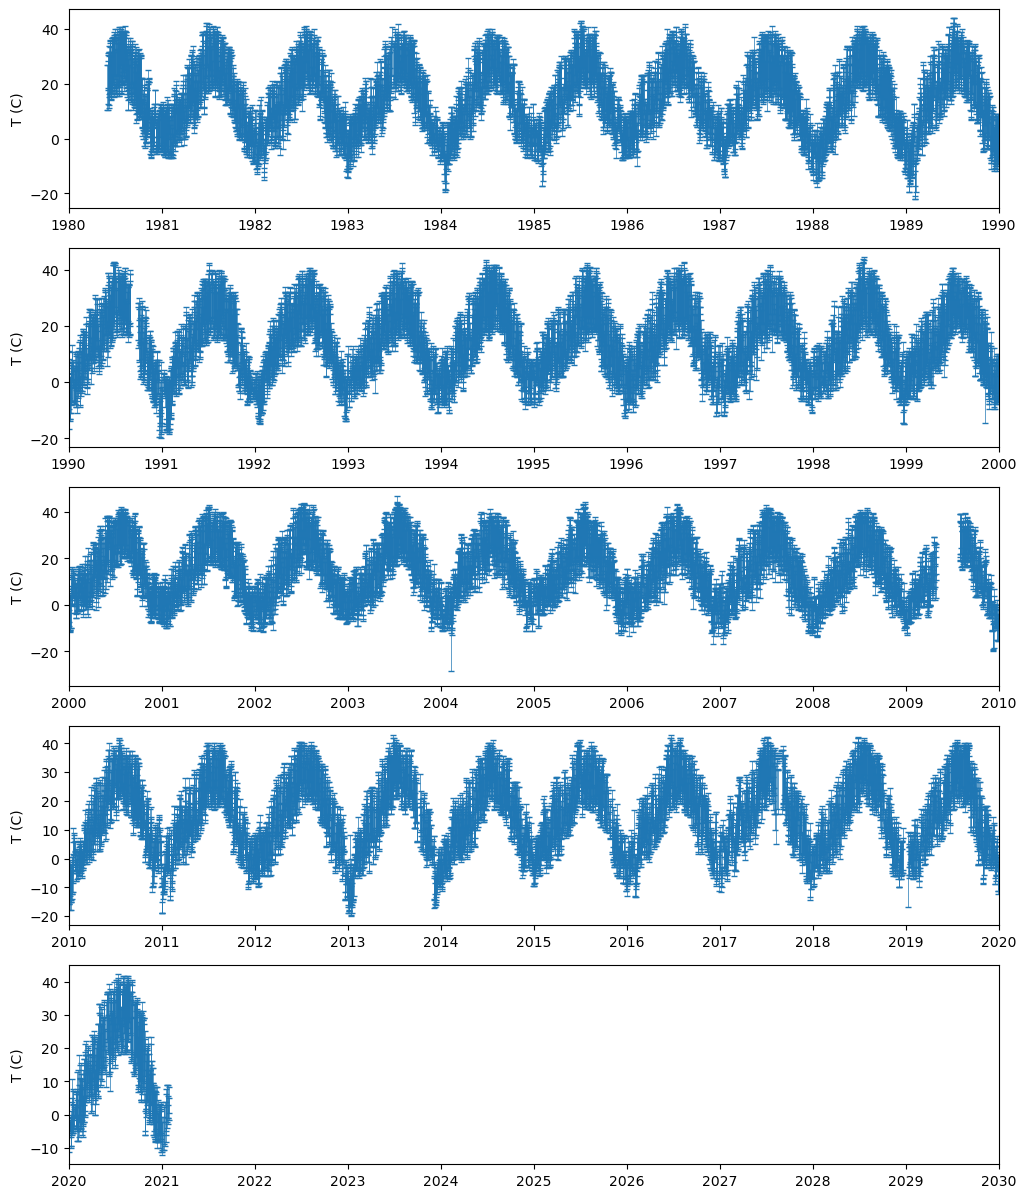

In [4]:
years = np.unique(data.DATE.dt.year)
decades = np.unique(years // 10)


fig, axs = plt.subplots(len(decades), 1, figsize=(12,3*len(decades)))
for decade, ax in zip(decades, axs):
    inds = np.where(data.DATE.dt.year // 10 == decade)[0]
    date, t0, tmin, tmax = data.DATE[inds], data.TOBS[inds], data.TMIN[inds], data.TMAX[inds]
    ax.errorbar(date, t0, yerr=[t0-tmin, tmax-t0],
             ls='none', fmt='',
             elinewidth=0.5, capsize=2, capthick=1,)
    ax.set(xlim=np.array([str(decade*10), str((decade+1)*10)], dtype=np.datetime64),
           ylabel='T (C)')

This is not a very nice way of looking at the data.  Let's try something else that removes the overall 365 day cycle.

In [5]:
from matplotlib import dates as mdates
class MyDateFormatter(mdates.DateFormatter):
    """Hack to get correct data from theta."""
    def date_to_theta(self, data):
        return 2*np.pi * (data - self.T0)/self.T

    def theta_to_date(self, theta):
        return self.T0 + self.T * np.asarray(theta) / (2*np.pi)

    def __init__(self, *v, T0=data.DATE[0], period='365Day', **kw):
        self.T = pd.to_timedelta(period)
        self.T0 = T0
        super().__init__(*v, **kw)

    def __call__(self, theta, 
                 pos=0):
        return (super().__call__(
                mdates.date2num(self.theta_to_date(theta)), pos))

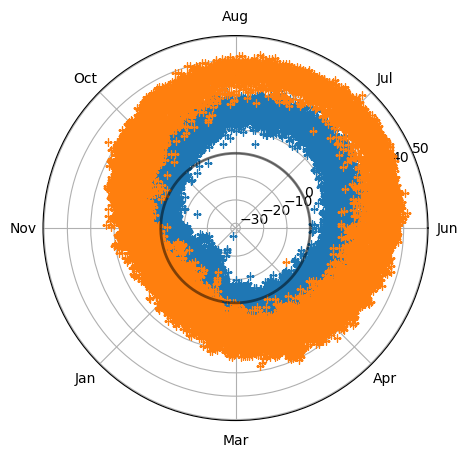

In [6]:
years = np.asarray((data.DATE - data.DATE[0])/pd.to_timedelta('365Day'))

dt = data.TMAX - data.TMIN

offset = dt.max()*years

fmt = fmt_month = MyDateFormatter('%b')
fmt_day = MyDateFormatter('%d')

plt.figure(figsize=(5,5))
ax = plt.axes(polar=True)
ax.plot(fmt_month.date_to_theta(data.DATE), data.TMIN, '+')
ax.plot(fmt_month.date_to_theta(data.DATE), data.TMAX, '+')
ax.xaxis.set_major_formatter(fmt_month);
th = np.linspace(0, 2*np.pi, 200);
ax.plot(th, 0*th, '-k', lw=2, alpha=0.5);
#ax.xaxis.set_minor_formatter(fmt_day)
#ax.xaxis.set_ticks(fmt.date_to_theta([pd.to_timedelta('1Day') for _N in range(365)]))
#ax.xaxis.set_ticks(['])
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
#ax.fill_between(2*np.pi * years, data.TMIN, data.TMAX, '+')
#DateFormatter

For finding cycles, the absolute date is probably not important, so we first convert the date to an integer representing the number of days since the start of the observations.  Also, some of the data is invalid (NaNs), so we filter these out:

In [7]:
%autoreload
from collections import namedtuple
from cycles.cycles import MatchCycles, orthogonal_matching_pursuit
t = (data.DATE - data.DATE[0]).dt.days.values
TimeTemp = namedtuple('TimeTemp', ['t', 'T'])
tTOBS, tTMIN, tTMAX = [TimeTemp(t[_inds], _d.values[_inds])
                       for _d in (data.TOBS, data.TMIN, data.TMAX)
                       for _inds in [np.where(~np.isnan(_d.values))[0]]]
tTs = dict(TOBS=tTOBS, TMIN=tTMIN, TMAX=tTMAX)

Here is an interactive explorer that allows one to play with different numbers of points, etc.

In [8]:
from ipywidgets import interact


@interact(
    key={"TOBS", "TMIN", "TMAX"},
    max_rank=(1, 20),
    N_df=3.0,
    Nt=(100, min(len(_tT.t) for _tT in tTs.values()), 100),
    seed=(3, 100),
)
def fit(key="TMIN", max_rank=5, Nt=100, N_df=3.0, seed=3):
    t, T = tTs[key]
    np.random.seed(seed)
    inds = np.sort(np.random.permutation(range(len(t)))[:Nt])
    t, T = t[inds], T[inds]
    print("Working...")
    print(len(t))
    m = MatchCycles(t=t, N_df=N_df, optimize_tol=1e-8)
    res = orthogonal_matching_pursuit(s=T - T.mean(), match=m, max_rank=max_rank)
    print("Working. Done.")
    Ts = [2 * np.pi / _r.w for _r in res[2]]
    print(Ts)
    fig, ax = plt.subplots(1, 1, figsize=(20, 4))
    ts = np.linspace(t.min(), t.max(), 1000)

    def T_fit(t):
        return (
            T.mean()
            + sum(_a * m.eval(t, _f_d) for _a, _f_d in zip(res.a, res.f_d)).ravel()
        )

    ax.plot(t, T, ".k", label=f"{Nt} data points")
    ax.plot(ts, T_fit(ts), "-", label="Fit")

    # Compute residuals
    t_, T_ = tTs[key]
    Tres = T_fit(t) - T
    Tres_ = T_fit(t_) - T_
    ax.plot(t, Tres, "--k", alpha=0.5, label="Residuals (fit data)")
    ax.plot(t_, Tres_, "--", alpha=0.5, label="Residuals (all data)")
    ax.set(
        title=f"L2 Residuals: "
        + f"{np.sqrt(np.mean(abs(Tres_)**2)):.2f}C (all data), "
        + f"{np.sqrt(np.mean(Tres**2)):.2f}C (fit data)",
        xlabel="day",
        ylabel="T [°C]",
    ),

    plt.legend()

interactive(children=(Dropdown(description='key', index=2, options=('TMAX', 'TOBS', 'TMIN'), value='TMIN'), In…

Here we randomly sample `Nt` days from the data, fit the best cycle, and then look at the mean and standard deviation of `Nsamples` to estimate the uncertainty.

In [9]:
from uncertainties import ufloat
def get_Ts(tT, Nt=200, Nsamples=10, N_df=3.0, Nw=5, seed=3, label=''):
    np.random.seed(seed)
    Ts = []
    for s in range(Nsamples):
        inds = np.random.permutation(len(tT.t))[:Nt]
        t, T = tT.t[inds], tT.T[inds]
        m = MatchCycles(t=t, N_df=N_df, optimize_tol=1e-8)
        res = orthogonal_matching_pursuit(s=T-T.mean(), match=m, max_rank=Nw)
        del m
        Ts.append([2*np.pi / _r.w for _r in res[2]])
    Ts = np.asarray(Ts)
    if label:
        print(label, ["{:+.2uS}".format(ufloat(*_t)) for _t in zip(Ts.mean(axis=0), Ts.std(axis=0))])
    return Ts

In [10]:
kw = dict(Nt=100, Nsamples=100)
Ts = get_Ts(tTMAX, label='TMAX', **kw)
Ts = get_Ts(tTMIN, label='TMIN', **kw)

TMAX ['+365.23(25)', '+0.6(5.5)e+14', '+0.6(4.2)e+03', '+0.4(4.0)e+13', '+21(35)']
TMIN ['+365.20(26)', '-0.7(6.6)e+10', '+0.4(2.3)e+02', '+0.4(1.5)e+02', '+0.6(6.2)e+10']


This gives us the extraction quoted in the 2-pager: $T_{\max} = 365.2(2)$. Including more points allows us to improve the error bound:

In [11]:
kw = dict(Nt=1000, Nsamples=20)
Ts = get_Ts(tTMAX, label='TMAX', **kw)
Ts = get_Ts(tTMIN, label='TMIN', **kw)

TMAX ['+365.246(86)', '+182.70(14)', '+125(12)', '+6.5(8.7)e+03', '+0.6(1.3)e+02']
TMIN ['+365.216(63)', '+182.58(13)', '+0.4(1.6)e+14', '+2.0(5.9)e+03', '+2.5(6.5)e+03']


Here we generate some data-files that can be used in the [Cycles.org](cycles.org) analyzer:

In [12]:
key = 'TMAX'
tT = tTs[key]
seed = 3
results = {}
day = np.timedelta64(1, 'D')
for N in [100, 1000, 10000]:
    np.random.seed(seed)
    inds = sorted(np.random.permutation(len(tT.t))[:N])
    t = tT.t[inds]
    T = tT.T[inds]
    _date = [(data.DATE[0] + _t*day).strftime("%Y-%m-%d") for _t in t]
    numpy.savetxt(f"{key}_{seed}_{N}.csv",
                  np.transpose([_date, T]),
                  fmt=["%s", "%s"],
                  header="date, value",
                  comments='',
                  delimiter=", ")
    m = MatchCycles(t=t, N_df=3, optimize_tol=1e-8)
    res = orthogonal_matching_pursuit(s=T-T.mean(), match=m, max_rank=5)
    print(N, [2*np.pi / _r.w for _r in res[2]])
    results[N] = (t, T, m, res)

100 [365.244125031064, 6.4343734238540655, 2.2126899599474137, 2.263394863770328, 2.7973403523384226]
1000 [365.353809120998, 182.4725323218347, 121.66163906126759, 177.72434958853057, 23.63923107942782]
10000 [365.2493696581372, 182.68813984607795, 121.71846315365364, 9052.575998188731, 178.21302192831544]


*(Run the above cell first to generate these files.)*

* 100 points: [`TMAX_3_100.csv`](TMAX_3_100.csv)
* 1000 points: [`TMAX_3_1000.csv`](TMAX_3_1000.csv)
* 10000 points: [`TMAX_3_10000.csv`](TMAX_3_10000.csv)

## Plot for 2-pager

Here is the code to generate the plot in the 2-page summary document:

In [13]:
import mmf_setup; # mmf_setup.nbinit()

In [14]:
import mmf_setup; # mmf_setup.nbinit()
%pylab inline --no-import-all
import numpy as np
import pandas as pd
%load_ext autoreload

import sys;sys.path.append('../')

# Read the data
%pylab inline --no-import-all
import pandas as pd
from collections import namedtuple
from cycles.cycles import MatchCycles, orthogonal_matching_pursuit

datafile = '2478833.csv'
data = pd.read_csv(datafile, quotechar='"', parse_dates=[2])

t = (data.DATE - data.DATE[0]).dt.days.values
TimeTemp = namedtuple('TimeTemp', ['t', 'T'])
tTOBS, tTMIN, tTMAX = [TimeTemp(t[_inds], _d.values[_inds])
                       for _d in (data.TOBS, data.TMIN, data.TMAX)
                       for _inds in [np.where(~np.isnan(_d.values))[0]]]
tTs = dict(TOBS=tTOBS, TMIN=tTMIN, TMAX=tTMAX)

key = 'TMAX'
tT = tTs[key]
seed = 3
results = {}
day = np.timedelta64(1, 'D')
for N in [100, 1000, 10000]:
    np.random.seed(seed)
    inds = sorted(np.random.permutation(len(tT.t))[:N])
    t = tT.t[inds]
    T = tT.T[inds]
    _date = [(data.DATE[0] + _t*day).strftime("%Y-%m-%d") for _t in t]
    numpy.savetxt(f"TMAX_{seed}_{N}.csv",
                  np.transpose([_date, T]),
                  fmt=["%s", "%s"],
                  header="date, value",
                  comments='',
                  delimiter=", ")
    m = MatchCycles(t=t, N_df=3, optimize_tol=1e-8)
    res = orthogonal_matching_pursuit(s=T-T.mean(), match=m, max_rank=5)
    print(N, [2*np.pi / _r.w for _r in res[2]])
    results[N] = (t, T, m, res)

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib
100 [365.244125031064, 6.4343734238540655, 2.2126899599474137, 2.263394863770328, 2.7973403523384226]
1000 [365.353809120998, 182.4725323218347, 121.66163906126759, 177.72434958853057, 23.63923107942782]
10000 [365.2493696581372, 182.68813984607795, 121.71846315365364, 9052.575998188731, 178.21302192831544]


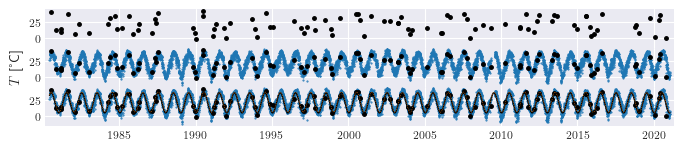

In [15]:
%autoreload
from cycles.mpl_styles import cycles_style

with cycles_style("figure*", height="0.2*width"):
    fig, axs = plt.subplots(3, 1)

    _t = np.arange(results[10000][0].max())

    ax = axs[0]
    t, T, m, res = results[100]
    _T = res[1][0] * m.eval(_t, res[2][0]) + T.mean()
    for ax in axs:
        ax.plot(data.DATE[0] + t*day, T, '.k', ms=5, zorder=100)

    ax = axs[2]
    ax.plot(data.DATE[0] + _t*day, _T, '-k', lw=1, zorder=100)

    t, T, m, res = results[10000]
    _T = res[1][0] * m.eval(_t, res[2][0]) + T.mean()

    for ax in axs[1:]:
        ax.plot(data.DATE[0] + t*day, T, '.C0', ms=1)

    ax = axs[2]
    ax.plot(data.DATE[0] + _t*day, _T, ':C1', lw=0.5, zorder=200)

    for ax in axs[:-1]:
        plt.setp(ax.get_xticklabels(), visible=False)

    dates = data.DATE[0] + np.array([t.min()-100, t.max()+100])*day
    for ax in axs:
        # Hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set(xlim=(dates[0], dates[-1]), ylim=(-15, 45));

    axs[1].set(ylabel="$T$ [°C]")

    plt.tight_layout(pad=0)
    plt.savefig(f"{key}_{seed}_{100}.pdf")

In [16]:
print (f"{key}_{seed}_{100}.pdf")

TMAX_3_100.pdf
